最終課題用のノートブックのなかに、犬と猫の画像を学習したモデルを作成して、分類を行なうプログラムを作成してください。

本レッスン内容で学習した流れに沿って、深層学習プログラムを作成してください
データの前処理や水増しの処理を入れてください
MobileNetV2 のモデルを利用してください（画像サイズは MobileNetV2 が対応する大きさへのリサイズが必要です）
必ず最後に evaluate() を実行して、正答率がわかるようにしてください。

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横96pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-06 17:16:04.272996: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[213.       , 207.       , 209.       ],
          [211.65625  , 202.96875  , 202.28125  ],
          [209.1875   , 197.375    , 192.20312  ],
          ...,
          [222.64062  , 226.64062  , 227.64062  ],
          [224.65625  , 228.65625  , 229.65625  ],
          [226.       , 230.       , 231.       ]],
 
         [[204.26562  , 193.5625   , 188.84375  ],
          [204.72754  , 192.69116  , 186.63916  ],
          [202.2273   , 188.94507  , 180.59229  ],
          ...,
          [227.6482   , 231.6482   , 232.6482   ],
          [229.13892  , 233.13892  , 234.13892  ],
          [230.03125  , 234.03125  , 235.03125  ]],
 
         [[196.82812  , 179.75     , 169.48438  ],
          [198.17188  , 181.94409  , 171.61548  ],
          [197.0935   , 182.1023   , 171.86328  ],
          ...,
          [231.20532  , 235.20532  , 237.11157  ],
          [232.0857   , 236.0857   , 237.99194  ],
          [232.45312  , 236.45312  , 238.35938  ]],
 
         ...,
 
         [[1

In [ ]:
# 分類名（cat/dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-06 17:17:18.381638: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


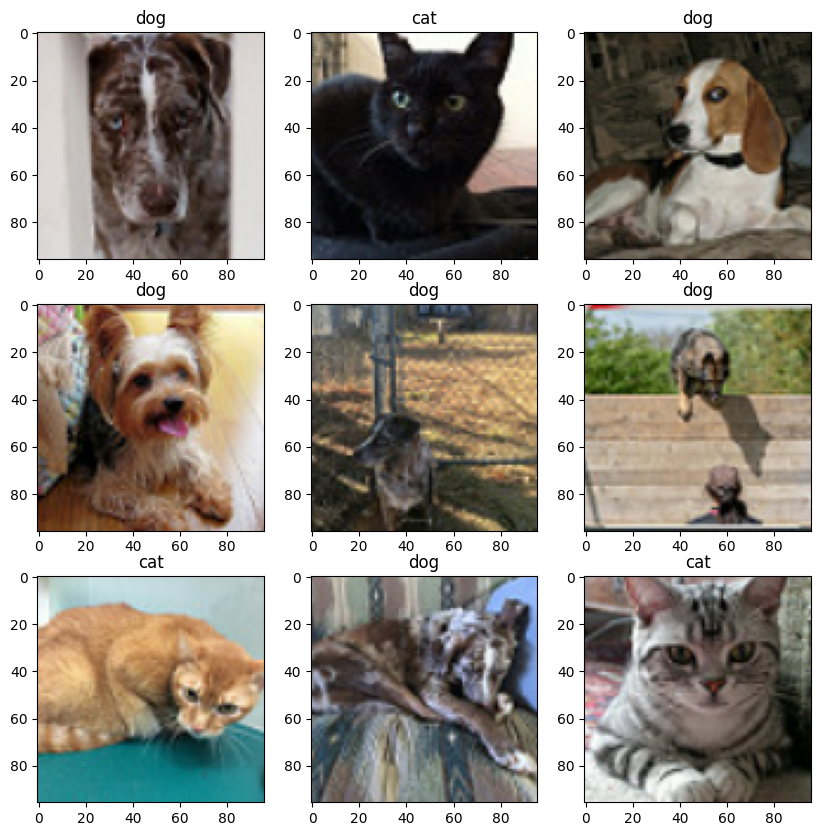

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [7]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [8]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [9]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

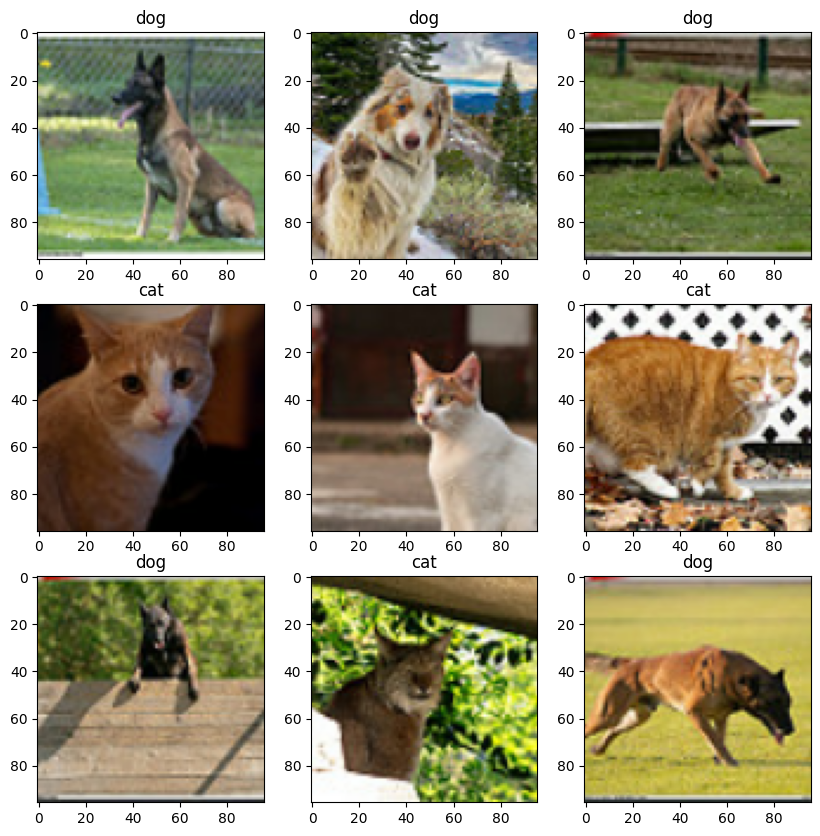

In [10]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [1]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(96, 96, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

NameError: name 'tf' is not defined

In [ ]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [ ]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [ ]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

In [ ]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

In [ ]:
# 分類した結果を確認する
pred_data

In [ ]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)